# Process astreroids dataset
Written by Kiyoaki Okudaira<br>
*Kyushu University Hanada Lab / University of Washington / IAU CPS SatHub<br>
(okudaira.kiyoaki.528@s.kyushu-u.ac.jp or kiyoaki@uw.edu)<br>
<br>
Process asteroids data set from NASA SENTRY / ESA AEGIS API and make asteroid event lists with IP from both data set.<br>
<br>
**History**<br>
coding 2026-02-03 : 1st coding<br>
update 2026-02-13 : Add velocity infinity for NASA<br>
update 2026-02-26 : Add velocity infinity for ESA<br>
<br>
This code is written for University of Washington ASTR 302 WINTER 2026 Project NEO.<br>
(c) 2026 Kiyoaki Okudaira - Kyushu University Hanada Lab (SSDL) / University of Washington / IAU CPS SatHub

### Parameters

In [1]:
event_range = 7 # time range considered to be the same event [day] | int

### Import and initial settings
**PATH settings**

In [2]:
base_PATH = "/Users/kiyoaki/VScode/projectneo-2026/"
output_PATH = base_PATH + "data"

**Standard libraries**

In [3]:
import pickle
from astropy.table import Table
from datetime import datetime, timedelta
import math
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u

**Global constants**

In [4]:
from astropy import units as u

EARTH_GM = 3.986004418e14 * u.m**3 / u.s**2
EARTH_GM_AU_DAY = EARTH_GM.to(u.au**3 / u.day**2)
RE = 6378.137 * u.km

### NASA SENTRY Dataset
**Import dataset**

In [5]:
with open(f'{output_PATH}/workspace_NASA_table.pkl', "rb") as f:
    NASA_table = pickle.load(f)
NASA_table = NASA_table.group_by("des")
NASA_table

fullname,des,ip,sigma_vi,ps,energy,sigma_mc,method,id,date,ts,v_inf
str24,str10,float64,float64,float64,float64,float64,str4,str8,str13,int64,float64
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.38,1425.0,2.1605,MC,a0101955,2290-09-25.12,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.36,1420.0,2.0531,MC,a0101955,2281-09-24.57,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.35,1420.0,0.9476,MC,a0101955,2272-09-24.38,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.32,1417.0,1.9442,MC,a0101955,2257-09-24.58,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.32,1420.0,2.7445,MC,a0101955,2254-09-24.85,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.27,1422.0,2.6204,MC,a0101955,2231-09-25.85,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.27,1421.0,2.3651,MC,a0101955,2231-09-25.66,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.27,1420.0,1.4184,MC,a0101955,2231-09-25.59,--,5.9916984432395
101955 Bennu (1999 RQ36),101955,1e-07,--,-5.26,1421.0,1.1506,MC,a0101955,2228-09-24.73,--,5.9916984432395


**Date handling**<br>
Round down date and format "YYYY-MM-DD"

In [6]:
NASA_table["date-round"] = "0000-00-00"
for row in NASA_table:
    dates = row["date"].split("-")
    row["date-round"] = dates[0] + "-" + dates[1] + "-" + str(math.floor(float(dates[2]))).zfill(2)

**Sum impact probability**<br>
Compute impact probability of an asteroid for a same date

In [7]:
dess = []
full_names = []
dates = []
ips = []
des_chrs = []
des_nums = []
v_infs = []

for object in NASA_table.groups:
    date_groups = object.group_by("date-round")
    for date_group in date_groups.groups:
        dess.append(date_group[0]["des"])
        full_names.append(date_group[0]["fullname"])
        dates.append(date_group[0]["date-round"])
        ips.append(date_group["ip"].sum())
        des_chr = date_group[0]["fullname"].split("(")[-1][0:-1]
        des_chrs.append(des_chr.replace(" ",""))
        v_infs.append(date_group[0]["v_inf"])
        if des_chr == date_group[0]["des"]:
            des_nums.append(None)
        else:
            des_nums.append(date_group[0]["des"])

NASA_cum_ip_date_table = Table({
    "des_chr": des_chrs,
    "des_num": des_nums,
    "des": dess,
    "fullname": full_names,
    "date": dates,
    "cum_ip": ips,
    "v_inf": v_infs
})
# NASA_cum_ip_date_table

Compute impact probability of an asteroid for near-by date

In [8]:
dess = []
full_names = []
date_starts = []
date_ends = []
ips = []
des_chrs = []
des_nums = []
v_infs = []

NASA_cum_ip_table = NASA_cum_ip_date_table.group_by("des")
for object in NASA_cum_ip_table.groups:
    object.sort("date")
    former_date = None
    for row in object:
        if former_date is None:
            des_chrs.append(row["des_chr"])
            des_nums.append(row["des_num"])
            v_infs.append(row["v_inf"])
            dess.append(row["des"])
            full_names.append(row["fullname"])
            date_starts.append(row["date"])
            date_ends.append(row["date"])
            ips.append(row["cum_ip"])
            former_date = datetime.strptime(row["date"],'%Y-%m-%d')
        elif datetime.strptime(row["date"],'%Y-%m-%d') < former_date + timedelta(days=event_range):
            ips[-1] = ips[-1] + row["cum_ip"]
            former_date = datetime.strptime(row["date"],'%Y-%m-%d')
            date_ends[-1] = row["date"]
        else:
            des_chrs.append(row["des_chr"])
            des_nums.append(row["des_num"])
            v_infs.append(row["v_inf"])
            dess.append(row["des"])
            full_names.append(row["fullname"])
            date_starts.append(row["date"])
            date_ends.append(row["date"])
            ips.append(row["cum_ip"])
            former_date = datetime.strptime(row["date"],'%Y-%m-%d')

NASA_cum_ip_table = Table({
    "des_chr": des_chrs,
    "des_num": des_nums,
    "des": dess,
    "fullname": full_names,
    "date_start": date_starts,
    "date_end": date_ends,
    "cum_ip": ips,
    "v_inf": v_infs
})

NASA_cum_ip_table.sort("des_chr")
NASA_cum_ip_table.group_by("des_chr")

NASA_cum_ip_table.write(f'{output_PATH}/NASA_cum_ip_table.csv', overwrite = True)
with open(f'{output_PATH}/workspace_NASA_cum_ip_table.pkl', 'wb') as f:
    pickle.dump(NASA_cum_ip_table, f)

NASA_cum_ip_table

des_chr,des_num,des,fullname,date_start,date_end,cum_ip,v_inf
str9,object,str10,str24,str10,str10,float64,float64
1950DA,29075,29075,29075 (1950 DA),2880-03-16,2880-03-16,0.000377,14.1
1979XB,None,1979 XB,(1979 XB),2113-12-14,2113-12-14,5.532e-07,23.7606234552547
1979XB,None,1979 XB,(1979 XB),2102-12-16,2102-12-16,1.158e-10,23.7606234552547
1979XB,None,1979 XB,(1979 XB),2086-12-16,2086-12-16,1.067e-07,23.7606234552547
1979XB,None,1979 XB,(1979 XB),2056-12-12,2056-12-12,1.915e-07,23.7606234552547
1991BA,None,1991 BA,(1991 BA),2051-01-18,2051-01-18,2.354e-08,16.7227981196217
1991BA,None,1991 BA,(1991 BA),2027-01-19,2027-01-19,2.107e-09,16.7227981196217
1991BA,None,1991 BA,(1991 BA),2073-01-19,2073-01-19,1.815e-07,16.7227981196217
1991BA,None,1991 BA,(1991 BA),2075-01-19,2075-01-20,1.361548e-07,16.7227981196217


### ESA AEGIS Dataset
**Import dataset**

In [9]:
with open(f'{output_PATH}/workspace_ESA_table.pkl', "rb") as f:
    ESA_table = pickle.load(f)
ESA_table = ESA_table.group_by("des")
ESA_table

des,name,diameter_m,diameter_estimated,vi_datetime_utc,ip_max,ps_max,vel_km_s,years_range,ip_cum,ps_cum,date,mjd,sigma,sigimp,dist_re,width_re,stretch_re,p_re,exp_energy_mt,ps,ts,a_au
str9,str8,float64,str5,str16,float64,float64,float64,str9,float64,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2056-12-12.902,72344.902,0.255,0.0,0.22,0.106,3530000.0,2.34e-07,55600.0,-2.82,0,2.566720060696914
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2065-12-16.463,75635.463,-1.11,0.0,1.1,0.091,35800000.0,2.72e-09,12100.0,-5.39,0,2.566720060696914
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2101-12-14.204,88781.204,-0.384,0.0,0.61,0.0,197000000.0,3.46e-09,24900.0,-5.3,0,2.566720060696914
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2113-12-14.753,93164.753,-0.706,0.0,0.25,0.028,1370000.0,4.94e-07,17800.0,-3.33,0,2.566720060696914
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2026-01-17.658,61057.658,0.225,0.494,1.16,48.969,2520000.0,2.55e-09,0.0197,-8.31,0,2.0996199747517377
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2027-01-19.190,61424.19,-3.669,0.0,0.54,0.013,313000.0,3.45e-09,0.0047,-9.07,0,2.0996199747517377
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2032-01-19.735,63250.735,-1.389,0.0,0.26,0.049,584000.0,6.15e-07,0.00933,-7.16,0,2.0996199747517377
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2036-01-19.840,64711.84,-1.121,0.0,0.44,0.516,5970000.0,7.48e-08,0.0105,-8.23,0,2.0996199747517377
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2038-01-18.946,65441.946,-4.2,0.0,0.66,0.037,273000.0,4.72e-10,0.00415,-10.82,0,2.0996199747517377


**Date handling**<br>
Round down date and format "YYYY-MM-DD"

In [10]:
ESA_table["date-round"] = "0000-00-00"
v_infs = []
for row in ESA_table:
    dates = row["date"].split("-")
    row["date-round"] = dates[0] + "-" + dates[1] + "-" + str(math.floor(float(dates[2]))).zfill(2)
    v_infs.append(round(np.sqrt(2*(((row["vel_km_s"]*u.km/u.s)**2)/2 - (EARTH_GM.to(u.km**3 / u.s**2)) * (1 / (RE)))),2))
ESA_table["v_inf"] = v_infs

In [11]:
ESA_table

des,name,diameter_m,diameter_estimated,vi_datetime_utc,ip_max,ps_max,vel_km_s,years_range,ip_cum,ps_cum,date,mjd,sigma,sigimp,dist_re,width_re,stretch_re,p_re,exp_energy_mt,ps,ts,a_au,date-round,v_inf
,,,,,,,,,,,,,,,,,,,,,,,,km / s
str9,str8,float64,str5,str16,float64,float64,float64,str9,float64,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str10,float64
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2056-12-12.902,72344.902,0.255,0.0,0.22,0.106,3530000.0,2.34e-07,55600.0,-2.82,0,2.566720060696914,2056-12-12,25.17
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2065-12-16.463,75635.463,-1.11,0.0,1.1,0.091,35800000.0,2.72e-09,12100.0,-5.39,0,2.566720060696914,2065-12-16,25.17
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2101-12-14.204,88781.204,-0.384,0.0,0.61,0.0,197000000.0,3.46e-09,24900.0,-5.3,0,2.566720060696914,2101-12-14,25.17
1979XB,--,500.0,True,2056-12-12 21:38,2.34e-07,-2.82,27.54,2056-2113,7.34e-07,-2.7,2113-12-14.753,93164.753,-0.706,0.0,0.25,0.028,1370000.0,4.94e-07,17800.0,-3.33,0,2.566720060696914,2113-12-14,25.17
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2026-01-17.658,61057.658,0.225,0.494,1.16,48.969,2520000.0,2.55e-09,0.0197,-8.31,0,2.0996199747517377,2026-01-17,16.49
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2027-01-19.190,61424.19,-3.669,0.0,0.54,0.013,313000.0,3.45e-09,0.0047,-9.07,0,2.0996199747517377,2027-01-19,16.49
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2032-01-19.735,63250.735,-1.389,0.0,0.26,0.049,584000.0,6.15e-07,0.00933,-7.16,0,2.0996199747517377,2032-01-19,16.49
1991BA,--,6.0,True,2032-01-19 17:37,6.15e-07,-7.16,19.92,2026-2115,5.29e-06,-6.74,2036-01-19.840,64711.84,-1.121,0.0,0.44,0.516,5970000.0,7.48e-08,0.0105,-8.23,0,2.0996199747517377,2036-01-19,16.49


**Sum impact probability**<br>
Compute impact probability of an asteroid for a same date

In [12]:
dess = []
full_names = []
dates = []
ips = []
des_chrs = []
des_nums = []
v_inf = []

for object in ESA_table.groups:
    date_groups = object.group_by("date-round")
    for date_group in date_groups.groups:
        dess.append(date_group[0]["des"])
        full_names.append(date_group[0]["name"])
        dates.append(date_group[0]["date-round"])
        ips.append(date_group["p_re"].sum())
        v_inf.append(date_group[0]["v_inf"])
        try:
            date_group[0]["name"].mask
            des_chrs.append(date_group[0]["des"])
            des_nums.append(None)
        except:
            des_chrs.append(date_group[0]["name"])
            des_nums.append(date_group[0]["des"])

ESA_cum_ip_date_table = Table({
    "des_chr": des_chrs,
    "des_num": des_nums,
    "des": dess,
    "name": full_names,
    "date": dates,
    "cum_ip": ips,
    "v_inf": v_inf
})
# ESA_cum_ip_date_table

Compute impact probability of an asteroid for near-by date

In [13]:
dess = []
full_names = []
date_starts = []
date_ends = []
ips = []
des_chrs = []
des_nums = []
v_inf = []

ESA_cum_ip_table = ESA_cum_ip_date_table.group_by("des")
for object in ESA_cum_ip_table.groups:
    object.sort("date")
    former_date = None
    for row in object:
        if former_date is None:
            des_chrs.append(row["des_chr"])
            des_nums.append(row["des_num"])
            dess.append(row["des"])
            full_names.append(row["name"])
            date_starts.append(row["date"])
            date_ends.append(row["date"])
            ips.append(row["cum_ip"])
            former_date = datetime.strptime(row["date"],'%Y-%m-%d')
            v_inf.append(row["v_inf"])
        elif datetime.strptime(row["date"],'%Y-%m-%d') < former_date + timedelta(days=event_range):
            ips[-1] = ips[-1] + row["cum_ip"]
            former_date = datetime.strptime(row["date"],'%Y-%m-%d')
            date_ends[-1] = row["date"]
        else:
            des_chrs.append(row["des_chr"])
            des_nums.append(row["des_num"])
            dess.append(row["des"])
            full_names.append(row["name"])
            date_starts.append(row["date"])
            date_ends.append(row["date"])
            ips.append(row["cum_ip"])
            former_date = datetime.strptime(row["date"],'%Y-%m-%d')
            v_inf.append(row["v_inf"])

ESA_cum_ip_table = Table({
    "des_chr": des_chrs,
    "des_num": des_nums,
    "des": dess,
    "name": full_names,
    "date_start": date_starts,
    "date_end": date_ends,
    "cum_ip": ips,
    "v_inf": v_inf
})

ESA_cum_ip_table.sort("des_chr")
ESA_cum_ip_table.group_by("des_chr")

ESA_cum_ip_table.write(f'{output_PATH}/ESA_cum_ip_table.csv', overwrite = True)
with open(f'{output_PATH}/workspace_ESA_cum_ip_table.pkl', 'wb') as f:
    pickle.dump(ESA_cum_ip_table, f)

ESA_cum_ip_table

des_chr,des_num,des,name,date_start,date_end,cum_ip,v_inf
str9,object,str9,str8,str10,str10,float64,float64
1979XB,None,1979XB,--,2056-12-12,2056-12-12,2.34e-07,25.17
1979XB,None,1979XB,--,2065-12-16,2065-12-16,2.72e-09,25.17
1979XB,None,1979XB,--,2101-12-14,2101-12-14,3.46e-09,25.17
1979XB,None,1979XB,--,2113-12-14,2113-12-14,4.94e-07,25.17
1991BA,None,1991BA,--,2075-01-20,2075-01-20,1.85e-09,16.49
1991BA,None,1991BA,--,2077-01-19,2077-01-19,4.46e-09,16.49
1991BA,None,1991BA,--,2078-01-19,2078-01-19,1.594e-06,16.49
1991BA,None,1991BA,--,2089-01-19,2089-01-19,1.94e-08,16.49
1991BA,None,1991BA,--,2091-01-19,2091-01-19,4.68e-10,16.49


### Compare objects listed in NASA with those listed in ESA
**Check objects**

In [14]:
# NASA_cum_ip_table
# ESA_cum_ip_table
NASA_cum_ip_table["both_listed"] = False
ESA_cum_ip_table["both_listed"] = False
NASA_cum_ip_table["both_event"] = False
ESA_cum_ip_table["both_event"] = False

for row in NASA_cum_ip_table:
    if str(row["des_chr"]) in ESA_cum_ip_table["des_chr"]:
        row["both_listed"] = True

for row in ESA_cum_ip_table:
    if str(row["des_chr"]) in NASA_cum_ip_table["des_chr"]:
        row["both_listed"] = True

**Check event date**<br>
If both NASA and ESA list have the same object and approximately the same event date, give unique and the same event ID with format `{des_chr}_{date}`

In [15]:
NASA_event_ids = [""] * len(NASA_cum_ip_table)
ESA_event_ids = [""] * len(ESA_cum_ip_table)

i = 0
for row in NASA_cum_ip_table:
    if row["both_listed"]:
        idx = np.where(ESA_cum_ip_table["des_chr"] == row["des_chr"])[0]
        for f in idx:
            low_bound = datetime.strptime(row["date_start"],'%Y-%m-%d') - timedelta(days=event_range)
            high_bound = datetime.strptime(row["date_end"],'%Y-%m-%d') + timedelta(days=event_range)
            start_date = datetime.strptime(ESA_cum_ip_table[f]["date_start"],'%Y-%m-%d')
            end_date = datetime.strptime(ESA_cum_ip_table[f]["date_end"],'%Y-%m-%d')
            datetime.strptime(row["date_start"],'%Y-%m-%d')
            if (low_bound < start_date and start_date < high_bound) or (low_bound < end_date and end_date < high_bound):
                row["both_event"] = True
                ESA_cum_ip_table[f]["both_event"] = True
                NASA_event_ids[i] = f"{row["des_chr"]}_{row["date_start"]}"
                ESA_event_ids[f] = f"{row["des_chr"]}_{row["date_start"]}"
    i = i + 1

NASA_cum_ip_table["event_id"] = NASA_event_ids
ESA_cum_ip_table["event_id"] = ESA_event_ids

In [16]:
NASA_cum_ip_table

des_chr,des_num,des,fullname,date_start,date_end,cum_ip,v_inf,both_listed,both_event,event_id
str9,object,str10,str24,str10,str10,float64,float64,bool,bool,str20
1950DA,29075,29075,29075 (1950 DA),2880-03-16,2880-03-16,0.000377,14.1,False,False,
1979XB,None,1979 XB,(1979 XB),2113-12-14,2113-12-14,5.532e-07,23.7606234552547,True,True,1979XB_2113-12-14
1979XB,None,1979 XB,(1979 XB),2102-12-16,2102-12-16,1.158e-10,23.7606234552547,True,False,
1979XB,None,1979 XB,(1979 XB),2086-12-16,2086-12-16,1.067e-07,23.7606234552547,True,False,
1979XB,None,1979 XB,(1979 XB),2056-12-12,2056-12-12,1.915e-07,23.7606234552547,True,True,1979XB_2056-12-12
1991BA,None,1991 BA,(1991 BA),2051-01-18,2051-01-18,2.354e-08,16.7227981196217,True,False,
1991BA,None,1991 BA,(1991 BA),2027-01-19,2027-01-19,2.107e-09,16.7227981196217,True,True,1991BA_2027-01-19
1991BA,None,1991 BA,(1991 BA),2073-01-19,2073-01-19,1.815e-07,16.7227981196217,True,True,1991BA_2073-01-19
1991BA,None,1991 BA,(1991 BA),2075-01-19,2075-01-20,1.361548e-07,16.7227981196217,True,True,1991BA_2075-01-19


In [17]:
ESA_cum_ip_table

des_chr,des_num,des,name,date_start,date_end,cum_ip,v_inf,both_listed,both_event,event_id
str9,object,str9,str8,str10,str10,float64,float64,bool,bool,str20
1979XB,None,1979XB,--,2056-12-12,2056-12-12,2.34e-07,25.17,True,True,1979XB_2056-12-12
1979XB,None,1979XB,--,2065-12-16,2065-12-16,2.72e-09,25.17,True,False,
1979XB,None,1979XB,--,2101-12-14,2101-12-14,3.46e-09,25.17,True,False,
1979XB,None,1979XB,--,2113-12-14,2113-12-14,4.94e-07,25.17,True,True,1979XB_2113-12-14
1991BA,None,1991BA,--,2075-01-20,2075-01-20,1.85e-09,16.49,True,True,1991BA_2075-01-19
1991BA,None,1991BA,--,2077-01-19,2077-01-19,4.46e-09,16.49,True,True,1991BA_2077-01-19
1991BA,None,1991BA,--,2078-01-19,2078-01-19,1.594e-06,16.49,True,True,1991BA_2078-01-19
1991BA,None,1991BA,--,2089-01-19,2089-01-19,1.94e-08,16.49,True,True,1991BA_2089-01-19
1991BA,None,1991BA,--,2091-01-19,2091-01-19,4.68e-10,16.49,True,False,


**List-up by event id**<br>
If only one of the 2 data set lists an event, the IP of the non-listed dataset will be `none`

In [18]:
des_chrs = []
des_nums = []
event_ids = []
ip_NASAs = []
ip_ESAs = []
v_inf_NASAs = []
v_inf_ESAs = []
v_infs = []

for row in NASA_cum_ip_table[NASA_cum_ip_table["both_event"]]:
    idx = np.where(ESA_cum_ip_table["event_id"] == row["event_id"])[0]
    for f in idx:
        des_chrs.append(row["des_chr"])
        des_nums.append(row["des_num"])
        event_ids.append(row["event_id"])
        ip_NASAs.append(row["cum_ip"])
        ip_ESAs.append(ESA_cum_ip_table[f]["cum_ip"])
        v_inf_NASAs.append(row["v_inf"])
        v_inf_ESAs.append(ESA_cum_ip_table[f]["v_inf"])
        v_infs.append(row["v_inf"])
        break

for row in NASA_cum_ip_table[(NASA_cum_ip_table["both_event"] == False)]:
    des_chrs.append(row["des_chr"])
    des_nums.append(row["des_num"])
    event_ids.append(f"{row["des_chr"]}_{row["date_start"]}")
    ip_NASAs.append(row["cum_ip"])
    ip_ESAs.append(None)
    v_inf_NASAs.append(row["v_inf"])
    v_inf_ESAs.append(None)
    v_infs.append(row["v_inf"])

for row in ESA_cum_ip_table[(ESA_cum_ip_table["both_event"] == False)]:
    des_chrs.append(row["des_chr"])
    des_nums.append(row["des_num"])
    event_ids.append(f"{row["des_chr"]}_{row["date_start"]}")
    ip_NASAs.append(None)
    ip_ESAs.append(row["cum_ip"])
    v_inf_NASAs.append(None)
    v_inf_ESAs.append(row["v_inf"])
    v_infs.append(row["v_inf"])

NASA_ESA_ip_table = Table({
    "des_chr": des_chrs,
    "des_num": des_nums,
    "event_id": event_ids,
    "ip_NASA": ip_NASAs,
    "ip_ESA": ip_ESAs,
    "v_inf_NASA": v_inf_NASAs,
    "v_inf_ESA": v_inf_ESAs,
    "v_inf": v_infs,
})

NASA_ESA_ip_table.sort("event_id")

NASA_ESA_ip_table.write(f'{output_PATH}/NASA_ESA_ip_table.csv', overwrite = True)
with open(f'{output_PATH}/workspace_NASA_ESA_ip_table.pkl', 'wb') as f:
    pickle.dump(NASA_ESA_ip_table, f)

NASA_ESA_ip_table

des_chr,des_num,event_id,ip_NASA,ip_ESA,v_inf_NASA,v_inf_ESA,v_inf
str9,object,str20,object,object,object,object,float64
1950DA,29075,1950DA_2880-03-16,0.000377,None,14.1,None,14.1
1979XB,None,1979XB_2056-12-12,1.915e-07,2.34e-07,23.7606234552547,25.17,23.7606234552547
1979XB,None,1979XB_2065-12-16,None,2.72e-09,None,25.17,25.17
1979XB,None,1979XB_2086-12-16,1.067e-07,None,23.7606234552547,None,23.7606234552547
1979XB,None,1979XB_2101-12-14,None,3.46e-09,None,25.17,25.17
1979XB,None,1979XB_2102-12-16,1.158e-10,None,23.7606234552547,None,23.7606234552547
1979XB,None,1979XB_2113-12-14,5.532e-07,4.94e-07,23.7606234552547,25.17,23.7606234552547
1991BA,None,1991BA_2026-01-17,None,2.55e-09,None,16.49,16.49
1991BA,None,1991BA_2027-01-19,2.107e-09,3.45e-09,16.7227981196217,16.49,16.7227981196217


### Plot result
Scatter plot of the IP by NASA vs the IP by ESA. None will be handled as 0 in the plot.

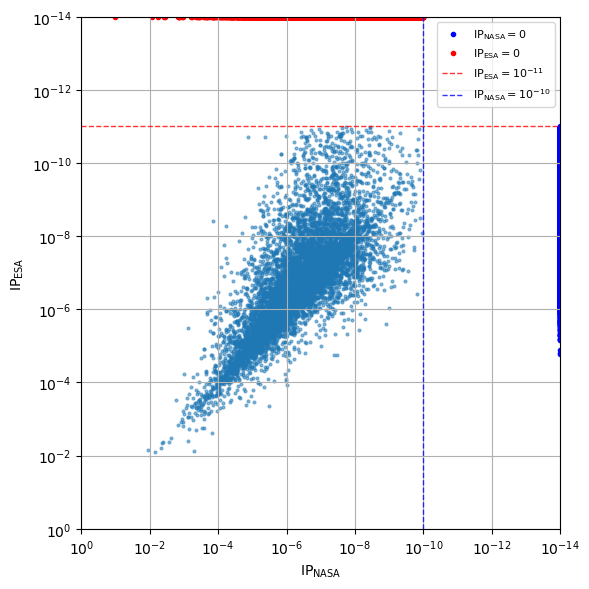

In [19]:
eps = 1e-14

x_raw = np.array([0 if x is None else x for x in NASA_ESA_ip_table["ip_NASA"]], dtype=float)
y_raw = np.array([0 if x is None else x for x in NASA_ESA_ip_table["ip_ESA"]], dtype=float)

x_plot = np.where(x_raw <= 0, eps, x_raw)
y_plot = np.where(y_raw <= 0, eps, y_raw)
x_zero_mask = (x_raw <= 0)
y_zero_mask = (y_raw <= 0)

plt.figure(figsize=(6,6))
plt.scatter(x_plot, y_plot, s=4, alpha=0.5)
plt.scatter(
    x_plot[x_zero_mask],
    y_plot[x_zero_mask],
    marker=".",
    color="blue",
    # s=8,
    label=r"$\mathrm{IP_{NASA}} = 0$"
)
plt.scatter(
    x_plot[y_zero_mask],
    y_plot[y_zero_mask],
    marker=".",
    color="red",
    # s=8,
    label=r"$\mathrm{IP_{ESA}} = 0$"
)

plt.axhline(
    y=1e-11,
    color="red",
    linestyle="--",
    linewidth=1,
    alpha=0.8,
    label=r"$\mathrm{IP_{ESA}} = 10^{-11}$"
)

plt.axvline(
    x=1e-10,
    color="blue",
    linestyle="--",
    linewidth=1,
    alpha=0.8,
    label=r"$\mathrm{IP_{NASA}} = 10^{-10}$"
)

plt.xlabel(r"$\mathrm{IP_{NASA}}$")
plt.ylabel(r"$\mathrm{IP_{ESA}}$")

plt.xscale("log")
plt.yscale("log")

plt.xlim(1, eps)
plt.ylim(1, eps)

plt.grid()
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

Scatter plot of the V_inf by NASA vs the V_inf by ESA.

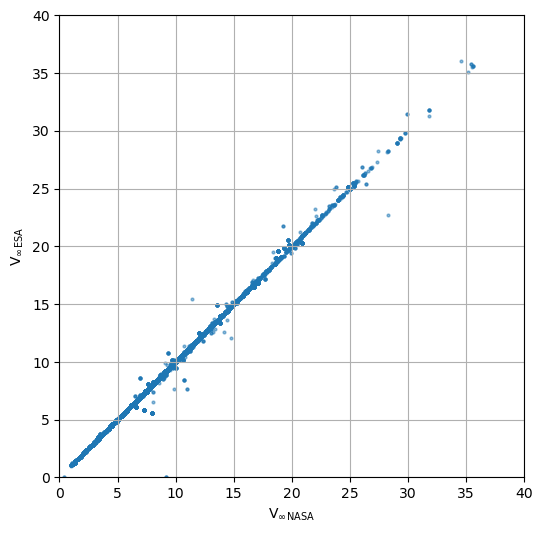

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(NASA_ESA_ip_table["v_inf_NASA"], NASA_ESA_ip_table["v_inf_ESA"], s=4, alpha=0.5)
plt.xlabel(r"$\mathrm{{V_{\infty}}_{NASA}}$")
plt.ylabel(r"$\mathrm{{V_{\infty}}_{ESA}}$")
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.grid()
plt.show()